# Predicting Heart Disease

## Score: .95386

In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cb
from catboost import CatBoostClassifier
#%pip install torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = Path("playground-series-s6e2")
OUTPUT_DIR = Path(".")
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [18]:
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
train.head()

Train: (630000, 15)
Test: (270000, 14)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [19]:
target_col = "Heart Disease"
id_col = "id"
feature_cols = [c for c in train.columns if c not in (id_col, target_col)]

le = LabelEncoder()
y = le.fit_transform(train[target_col])

X_train = train[feature_cols].copy()
X_test = test[feature_cols].copy()

for col in feature_cols:
    if X_train[col].isna().any() or X_test[col].isna().any():
        med = X_train[col].median()
        X_train[col] = X_train[col].fillna(med)
        X_test[col] = X_test[col].fillna(med)

X_train["chol_exercise"] = X_train["Cholesterol"] * X_train["Exercise angina"]
X_test["chol_exercise"] = X_test["Cholesterol"] * X_test["Exercise angina"]
X_train["st_slope"] = X_train["ST depression"] * X_train["Slope of ST"]
X_test["st_slope"] = X_test["ST depression"] * X_test["Slope of ST"]
X_train["hr_age"] = X_train["Max HR"] * X_train["Age"]
X_test["hr_age"] = X_test["Max HR"] * X_test["Age"]
X_train["bp_age"] = X_train["BP"] * X_train["Age"]
X_test["bp_age"] = X_test["BP"] * X_test["Age"]

te_cols = ["Chest pain type", "Slope of ST", "Thallium"]
global_mean = float(y.mean())
m = 20
for col in te_cols:
    agg = pd.DataFrame({"_y": y}).groupby(X_train[col])["_y"].agg(["mean", "count"])
    smoothed = (agg["count"] * agg["mean"] + m * global_mean) / (agg["count"] + m)
    X_train[col + "_te"] = X_train[col].map(smoothed).fillna(global_mean)
    X_test[col + "_te"] = X_test[col].map(smoothed).fillna(global_mean)

scaler_feat = StandardScaler()
X_tr_s = scaler_feat.fit_transform(X_train)
X_te_s = scaler_feat.transform(X_test)
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
kmeans.fit(X_tr_s)
for i in range(kmeans.n_clusters):
    d_tr = np.linalg.norm(X_tr_s - kmeans.cluster_centers_[i], axis=1)
    d_te = np.linalg.norm(X_te_s - kmeans.cluster_centers_[i], axis=1)
    X_train[f"dist_c{i}"] = d_tr
    X_test[f"dist_c{i}"] = d_te

print(f"Features: {len(X_train.columns)} columns")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")

Features: 32 columns
Target distribution: {0: 347546, 1: 282454}


In [20]:
param_grid = {"depth": [4, 5, 6], "lr": [0.03, 0.04, 0.05], "min_data_in_leaf": [15, 25, 35]}
n_est = 800
best_auc, best_params = 0, None
for depth in param_grid["depth"]:
    for lr in param_grid["lr"]:
        for min_leaf in param_grid["min_data_in_leaf"]:
            m = cb.CatBoostClassifier(iterations=n_est, depth=depth, learning_rate=lr, min_data_in_leaf=min_leaf, subsample=0.75, colsample_bylevel=0.75, random_seed=42, verbose=0)
            oof = cross_val_predict(m, X_train, y, cv=cv, method="predict_proba")[:, 1]
            auc = roc_auc_score(y, oof)
            if auc > best_auc:
                best_auc, best_params = auc, {"depth": depth, "lr": lr, "min_data_in_leaf": min_leaf}
print(f"Best OOF AUC: {best_auc:.5f}, params: {best_params}")

Best OOF AUC: 0.95507, params: {'depth': 6, 'lr': 0.05, 'min_data_in_leaf': 15}


In [21]:
model = cb.CatBoostClassifier(iterations=n_est, depth=best_params["depth"], learning_rate=best_params["lr"], min_data_in_leaf=best_params["min_data_in_leaf"], subsample=0.75, colsample_bylevel=0.75, random_seed=42, verbose=0)
oof_cb = cross_val_predict(model, X_train, y, cv=cv, method="predict_proba")[:, 1]
xgb_model = xgb.XGBClassifier(n_estimators=n_est, max_depth=5, learning_rate=0.05, min_child_weight=20, subsample=0.75, colsample_bytree=0.75, random_state=42, eval_metric="auc")
oof_xgb = cross_val_predict(xgb_model, X_train, y, cv=cv, method="predict_proba")[:, 1]
best_w, best_auc = 0.0, roc_auc_score(y, oof_cb)
for w in [0, 0.1, 0.2, 0.3, 0.4]:
    oof_blend = (1 - w) * oof_cb + w * oof_xgb
    auc = roc_auc_score(y, oof_blend)
    if auc > best_auc:
        best_auc, best_w = auc, w
oof = (1 - best_w) * oof_cb + best_w * oof_xgb
print(f"CV AUC: {best_auc:.5f} (blend w_xgb={best_w})")

CV AUC: 0.95517 (blend w_xgb=0.4)


In [22]:
model.fit(X_train, y)
xgb_model.fit(X_train, y)
test_cb = model.predict_proba(X_test)[:, 1]
test_xgb = xgb_model.predict_proba(X_test)[:, 1]
test_proba = (1 - best_w) * test_cb + best_w * test_xgb

In [23]:
from collections import defaultdict
import inspect

SEED = 42
NSPLITS = 5

# Reload data Kaggle-style (lowercase columns, id as index)
path = DATA_DIR
dfs = []
for fl in ("train.csv", "test.csv"):
    df = pd.read_csv(path / fl, index_col=0)
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns.tolist()]
    dfs.append(df)
train, test = dfs

ystr = train.columns[-1]
base_features = [c for c in train.columns if c != ystr]

cols2comb = [
    "exercise_angina", "thallium", "chest_pain_type",
    "slope_of_st", "sex", "st_depression", "number_of_vessels_fluro",
    "ekg_results", "fbs_over_120",
]

statmetrics = ["mean", "count"]

X = train.drop(columns=ystr)
y = (train[ystr] == "Presence").astype(int)

X_test = test.copy()


def get_cat_feature_indices(X_):
    return [i for i, c in enumerate(X_.columns) if c.startswith("CAT_")]


def fe_foldwise(X_tr, X_val, y_tr):
    X_tr = X_tr.copy()
    X_val = X_val.copy()

    temp = pd.concat([X_tr, y_tr], axis=1)

    # casting
    for df in [X_tr, X_val]:
        df["age>55"] = (df["age"] > 55).astype(int)
        for col in df.columns:
            colname = f"CAT_{col}"
            df[colname] = df[col].astype(str).astype("category")

    # numeric interactions and derived
    for df in [X_tr, X_val]:
        df["hr_age"] = df["max_hr"] * df["age"]
        df["bp_age"] = df["bp"] * df["age"]
        df["st_slope"] = df["st_depression"] * df["slope_of_st"]
        df["chol_exercise"] = df["cholesterol"] * df["exercise_angina"]
        pred_max = (220 - df["age"]).clip(lower=10)
        df["max_hr_pct_pred"] = df["max_hr"] / pred_max
        df["risk_sum"] = df["number_of_vessels_fluro"] + df["thallium"] + df["exercise_angina"]

    # target statistics + smoothed target encoding
    global_mean = float(y_tr.mean())
    m_smooth = 20
    for bf in base_features:
        stats = temp.groupby(bf)[ystr].agg(statmetrics)
        for s in statmetrics:
            cname = f"target_{bf}_{s}"
            X_tr[cname] = X_tr[bf].map(stats[s])
            X_val[cname] = X_val[bf].map(stats[s])
        smoothed = (stats["count"] * stats["mean"] + m_smooth * global_mean) / (stats["count"] + m_smooth)
        X_tr[f"target_{bf}_smooth"] = X_tr[bf].map(smoothed).fillna(global_mean)
        X_val[f"target_{bf}_smooth"] = X_val[bf].map(smoothed).fillna(global_mean)

    # categorical combinations
    for i, c1 in enumerate(cols2comb[:-1]):
        for c2 in cols2comb[i + 1 :]:
            m2 = max(X_tr[c2].max(), X_val[c2].max()) + 1
            cname = f"{c1}_{c2}"
            X_tr[cname] = (
                (X_tr[c1] + 1 + (X_tr[c2] + 1) / (m2 + 1)) * (m2 + 1)
            ).astype("int16")
            X_val[cname] = (
                (X_val[c1] + 1 + (X_val[c2] + 1) / (m2 + 1)) * (m2 + 1)
            ).astype("int16")

    return X_tr, X_val


def fe_test(X_test_, X_train_, y_train_):
    X_test_ = X_test_.copy()
    temp = pd.concat([X_train_, y_train_], axis=1)

    X_test_["age>55"] = (X_test_["age"] > 55).astype(int)
    for col in X_test_.columns:
        colname = f"CAT_{col}"
        X_test_[colname] = X_test_[col].astype(str).astype("category")

    X_test_["hr_age"] = X_test_["max_hr"] * X_test_["age"]
    X_test_["bp_age"] = X_test_["bp"] * X_test_["age"]
    X_test_["st_slope"] = X_test_["st_depression"] * X_test_["slope_of_st"]
    X_test_["chol_exercise"] = X_test_["cholesterol"] * X_test_["exercise_angina"]
    pred_max = (220 - X_test_["age"]).clip(lower=10)
    X_test_["max_hr_pct_pred"] = X_test_["max_hr"] / pred_max
    X_test_["risk_sum"] = X_test_["number_of_vessels_fluro"] + X_test_["thallium"] + X_test_["exercise_angina"]

    global_mean = float(y_train_.mean())
    m_smooth = 20
    for bf in base_features:
        stats = temp.groupby(bf)[ystr].agg(statmetrics)
        for s in statmetrics:
            X_test_[f"target_{bf}_{s}"] = X_test_[bf].map(stats[s])
        smoothed = (stats["count"] * stats["mean"] + m_smooth * global_mean) / (stats["count"] + m_smooth)
        X_test_[f"target_{bf}_smooth"] = X_test_[bf].map(smoothed).fillna(global_mean)

    for i, c1 in enumerate(cols2comb[:-1]):
        for c2 in cols2comb[i + 1 :]:
            m2 = max(X_train_[c2].max(), X_test_[c2].max()) + 1
            cname = f"{c1}_{c2}"
            X_test_[cname] = (
                (X_test_[c1] + 1 + (X_test_[c2] + 1) / (m2 + 1)) * (m2 + 1)
            ).astype("int16")

    return X_test_


xgboost_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.02,
    "max_depth": 2,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "n_estimators": 5000,
    "min_child_weight": 10,
    "gamma": 1,
    "reg_lambda": 0.01,
    "reg_alpha": 1.5,
    "tree_method": "hist",
    "n_jobs": -1,
    "random_state": SEED,
    "early_stopping_rounds": 300,
    "enable_categorical": True,
}

catboost_params = {
    "loss_function": "Logloss",
    "learning_rate": 0.02,
    "depth": 2,
    "subsample": 0.9,
    "iterations": 5000,
    "min_data_in_leaf": 1,
    "l2_leaf_reg": 1.002,
    "thread_count": -1,
    "random_seed": SEED,
    "early_stopping_rounds": 300,
    "bootstrap_type": "Bernoulli",
}

lgbm_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.02,
    "n_estimators": 4000,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "min_data_in_leaf": 30,
    "random_state": SEED,
    "n_jobs": -1,
}

models = {
    XGBClassifier: xgboost_params,
    CatBoostClassifier: catboost_params,
    LGBMClassifier: lgbm_params,
}

kf = KFold(n_splits=NSPLITS, shuffle=True, random_state=SEED)

oof_train_model = {}
oof_test_model = {}
cv_auc_model = defaultdict(list)

for modelClass, param in models.items():
    model_name = modelClass.__name__
    oof_train = np.zeros(len(X))
    oof_test = np.zeros(len(X_test))

    for fold, (tr, val) in enumerate(kf.split(X)):
        print(f"FOLD {fold + 1}/{NSPLITS} - {model_name}")

        X_tr_raw, X_val_raw = X.iloc[tr], X.iloc[val]
        y_tr, y_val = y.iloc[tr], y.iloc[val]

        X_tr, X_val = fe_foldwise(X_tr_raw, X_val_raw, y_tr)

        model = modelClass(**param)
        fit_kwargs = {
            "X": X_tr,
            "y": y_tr,
            "eval_set": [(X_val, y_val)],
        }
        if model_name != "LGBMClassifier":
            fit_kwargs["verbose"] = 2000

        if "cat_features" in inspect.signature(model.fit).parameters:
            cat_features = get_cat_feature_indices(X_tr)
            fit_kwargs["cat_features"] = cat_features

        model.fit(**fit_kwargs)

        oof_train[val] = model.predict_proba(X_val)[:, 1]

        X_test_fe = fe_test(X_test, X_tr_raw, y_tr)
        oof_test += model.predict_proba(X_test_fe)[:, 1] / NSPLITS
        cv_auc_model[model_name].append(roc_auc_score(y[val], oof_train[val]))

    oof_train_model[model_name] = oof_train
    oof_test_model[model_name] = oof_test

# Evaluation per model
for modelClass in models.keys():
    model_name = modelClass.__name__
    print(f"\n{model_name} OOF AUC: {roc_auc_score(y, oof_train_model[model_name]):.6f}")
    print(
        f"{model_name} CV AUC mean: {np.mean(cv_auc_model[model_name]):.6f}, std: +-{np.std(cv_auc_model[model_name]):.5f}"
    )

# Stacking: meta-learner on OOF predictions (learns how to combine, not fixed weights)
X_oof_tr = pd.DataFrame.from_dict(oof_train_model)
X_oof_test = pd.DataFrame.from_dict(oof_test_model)

meta = LogisticRegression(C=0.1, max_iter=500, random_state=SEED)
meta.fit(X_oof_tr, y)

oof_tr_final = pd.Series(meta.predict_proba(X_oof_tr)[:, 1], index=X_oof_tr.index)
oof_test_final = pd.Series(meta.predict_proba(X_oof_test)[:, 1], index=X_oof_test.index)
stack_auc = roc_auc_score(y, oof_tr_final)
print(f"\nStacked (meta-learner) OOF AUC: {stack_auc:.6f}")

# Set variables used by later cells
oof = oof_tr_final.values
test_proba = oof_test_final.values

# Ensure id column exists for submission
test["id"] = test.index

FOLD 1/5 - XGBClassifier
[0]	validation_0-auc:0.88938
[2000]	validation_0-auc:0.95544
[2174]	validation_0-auc:0.95543
FOLD 2/5 - XGBClassifier
[0]	validation_0-auc:0.89147
[2000]	validation_0-auc:0.95564
[2149]	validation_0-auc:0.95564
FOLD 3/5 - XGBClassifier
[0]	validation_0-auc:0.89159
[2000]	validation_0-auc:0.95621
[2422]	validation_0-auc:0.95620
FOLD 4/5 - XGBClassifier
[0]	validation_0-auc:0.88938
[2000]	validation_0-auc:0.95511
[2290]	validation_0-auc:0.95511
FOLD 5/5 - XGBClassifier
[0]	validation_0-auc:0.89198
[1842]	validation_0-auc:0.95530
FOLD 1/5 - CatBoostClassifier
0:	learn: 0.6781625	test: 0.6781886	best: 0.6781886 (0)	total: 127ms	remaining: 10m 34s
2000:	learn: 0.2665560	test: 0.2678501	best: 0.2678501 (2000)	total: 4m 1s	remaining: 6m 1s
4000:	learn: 0.2658871	test: 0.2675157	best: 0.2675157 (4000)	total: 7m 52s	remaining: 1m 58s
4999:	learn: 0.2656839	test: 0.2674671	best: 0.2674671 (4999)	total: 9m 48s	remaining: 0us

bestTest = 0.2674670568
bestIteration = 4999



Confusion matrix (OOF, threshold=0.5)
Rows: true, Cols: predicted |  Absence   Presence
[[315045  32501]
 [ 37292 245162]]


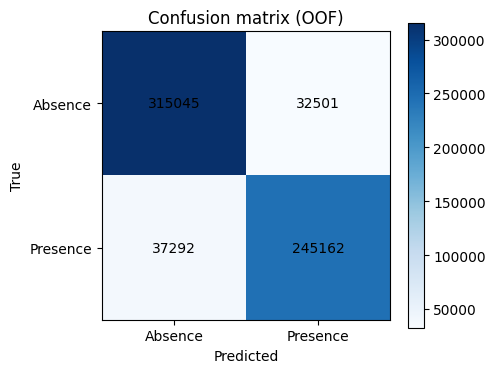

In [24]:
y_pred = (oof >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred)
print("Confusion matrix (OOF, threshold=0.5)")
print("Rows: true, Cols: predicted |  Absence   Presence")
print(cm)
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0, 1], ["Absence", "Presence"])
plt.yticks([0, 1], ["Absence", "Presence"])
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.title("Confusion matrix (OOF)")
plt.tight_layout()
plt.show()

In [25]:
sub = pd.DataFrame({"id": test["id"], "Heart Disease": test_proba})
sub.to_csv(OUTPUT_DIR / "submission.csv", index=False)
print(f"Submission saved to {OUTPUT_DIR / 'submission.csv'}")
sub.head(10)

Submission saved to submission.csv


,id,Heart Disease
id,,
630000,630000,0.945936
630001,630001,0.040163
630002,630002,0.959707
630003,630003,0.038872
630004,630004,0.120840
630005,630005,0.958481
630006,630006,0.038983
630007,630007,0.597462
630008,630008,0.960212
